In [32]:
%load_ext autoreload
%autoreload 2
import os

# ensure is in parent directory
try:
    os.chdir("../../RUG-HandRec/")
except:
    pass

import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm
from collections import defaultdict

import numpy as np
from scipy.ndimage import label, center_of_mass
from scipy.spatial.distance import cdist
from utils.transforms import remove_ornaments, set_adaptive_threshold

import numpy as np
import math


from typing import List, Tuple, Optional

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


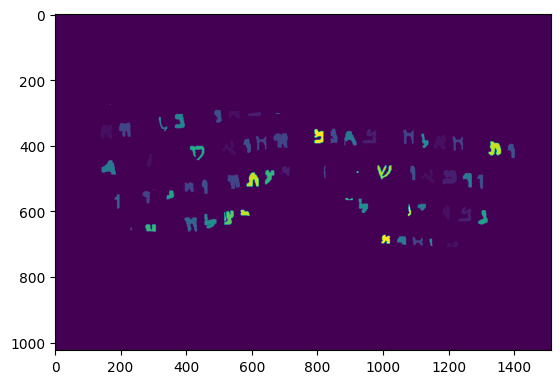

In [33]:
# show random image
masks_folder = "experiments/Masks/"
masks = os.listdir(masks_folder)
random_mask = np.random.choice(masks)
image = np.array(Image.open(masks_folder + random_mask))
plt.imshow(image)

[   2    6    7   17   20   21   22   22   89  116  131  156  181  251
  352  358  375  378  392  410  412  439  451  453  457  486  509  520
  522  528  558  584  584  592  595  620  620  637  648  667  669  673
  683  683  705  727  730  779  817  834  834  852  855  863  898  964
 1011 1046 1098 1104 1137 1140 1151 1217 1389 1455]


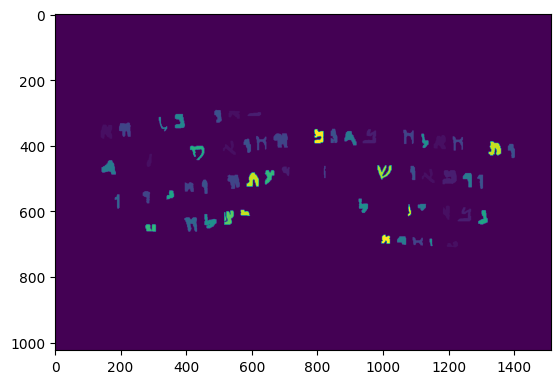

In [34]:
binary_image = np.where(image > 0, 1, 0)
allowed_pixels = remove_ornaments(binary_image, set_adaptive_threshold(binary_image))
image_without_ornaments = np.where(allowed_pixels > 0, image, 0)
plt.imshow(image_without_ornaments)

In [35]:
class Point:
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label

    def __repr__(self):
        return f'Point({self.x}, {self.y}, "{self.label}")'


In [39]:
def find_centers_of_characters(img: np.ndarray, distance_threshold=0):
    unique_values = np.unique(img)
    unique_values = unique_values[unique_values != 0]  # Exclude background value (0)

    points = []

    for value in unique_values:
        binary_img = np.where(img == value, value, 0).astype(img.dtype)

        # Label connected components
        labeled_img, num_components = label(binary_img)

        # Calculate centers
        value_centers = center_of_mass(binary_img, labeled_img, range(1, num_components + 1))

        # Convert coordinates to integers
        int_centers = [tuple(map(int, center)) for center in value_centers]

        # Merge centers that are close together
        merged_centers = []
        for idx, center in enumerate(int_centers):
            if center in merged_centers:
                continue

            # Find the centers that are within the distance threshold
            distances = cdist([center], int_centers)[0]
            close_centers_idx = np.where(distances <= distance_threshold)[0]

            # Calculate the new combined center
            new_center = np.mean([int_centers[i] for i in close_centers_idx], axis=0)
            merged_centers.append(Point(int(new_center[0]), int(new_center[1]), value))

        points.extend(merged_centers)

    return points


points = find_centers_of_characters(image_without_ornaments)
print(points)



[Point(304, 545, "1"), Point(357, 156, "1"), Point(390, 1171, "1"), Point(408, 532, "1"), Point(447, 287, "1"), Point(494, 1137, "1"), Point(603, 1191, "1"), Point(702, 1210, "1"), Point(305, 607, "2"), Point(375, 960, "2"), Point(476, 702, "2"), Point(496, 1200, "2"), Point(613, 1249, "2"), Point(350, 213, "5"), Point(372, 1074, "5"), Point(383, 688, "5"), Point(390, 626, "5"), Point(391, 1224, "5"), Point(481, 820, "5"), Point(509, 544, "5"), Point(526, 407, "5"), Point(554, 279, "5"), Point(692, 1103, "5"), Point(309, 496, "6"), Point(372, 848, "6"), Point(399, 586, "6"), Point(414, 1389, "6"), Point(482, 1089, "6"), Point(507, 1295, "6"), Point(524, 456, "6"), Point(568, 190, "8"), Point(637, 414, "8"), Point(376, 897, "10"), Point(468, 164, "10"), Point(501, 1257, "10"), Point(586, 1116, "10"), Point(688, 1055, "10"), Point(326, 379, "11"), Point(336, 325, "12"), Point(388, 1124, "12"), Point(585, 936, "12"), Point(634, 469, "12"), Point(694, 1143, "12"), Point(551, 351, "14"), Po

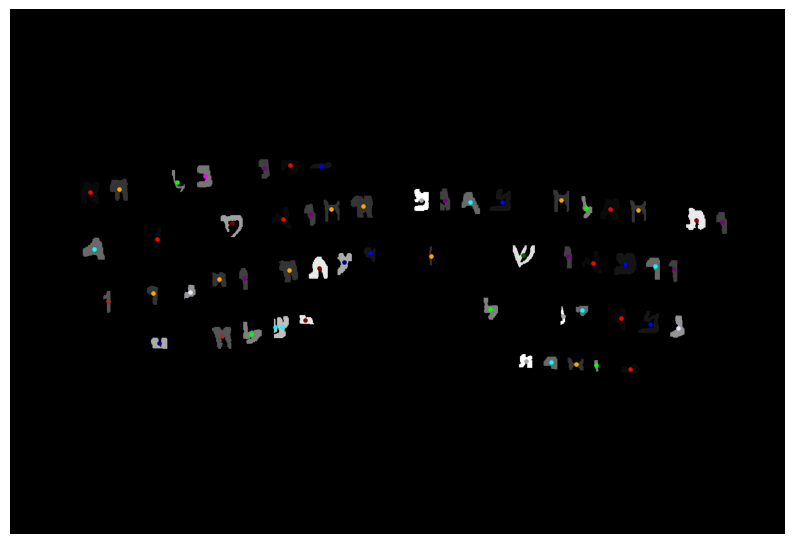

In [46]:
import matplotlib.pyplot as plt

label_to_color = {
    "1": "red",
    "2": "blue",
    "3": "green",
    "4": "yellow",
    "5": "orange",
    "6": "purple",
    "7": "pink",
    "8": "brown",
    "9": "gray",
    "10": "cyan",
    "11": "magenta",
    "12": "lime",
    "13": "teal",
    "14": "lavender",
    "15": "maroon",
    "16": "navy",
    "17": "olive",
    "18": "aqua",
    "19": "limegreen",
    "20": "gold",
    "21": "darkgreen",
    "22": "darkred",
    "23": "darkblue",
    "24": "darkgray",
    "25": "darkorange",
    "26": "darkorchid",
    "27": "darkcyan",
}


def plot_points_on_image(img: np.ndarray, points, label_to_color):
    plt.figure(figsize=(10, 10))  # Set the figure size, you can adjust this as needed
    plt.imshow(img, cmap='gray')  # Display the image in grayscale

    for point in points:
        plt.scatter(point.y, point.x, s=5, color=label_to_color[str(point.label)])

    plt.axis('off')  # remove the axis
    plt.show()  # show the plot


plot_points_on_image(image_without_ornaments, points, label_to_color)


In [36]:

def greate_graph(points):
    graph = defaultdict(list)
    for i, point in enumerate(points):
        for j, other_point in enumerate(points):
            if i == j:
                continue
            angle = math.atan2(other_point.y - point.y, other_point.x - point.x)
            graph[point].append((other_point, angle))
    return graph


def distance_between_points(p1: Tuple[int, int], p2: Tuple[int, int]) -> float:
    return math.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)


def find_starting_point(points: List[Tuple[int, int]]) -> Optional[Tuple[int, int]]:
    try:
        anchor_point = (1500, 0)
        return min(points, key=lambda point: distance_between_points(anchor_point, point))
    except ValueError:
        print("No starting point found")
        return None


def find_next_point_in_line(current_point: Tuple[int, int], points: List[Tuple[int, int]],
                            angle_threshold=50) -> Optional[Tuple[int, int]]:
    points_on_left = [point for point in points if point[0] < current_point[0] and abs(
        point[1] - current_point[1]) < angle_threshold]
    return min(points_on_left, key=lambda point: distance_between_points(current_point, point),
               default=None)


def find_next_line_start(points: List[Tuple[int, int]], last_point: Tuple[int, int]) -> Optional[
    Tuple[int, int]]:
    remaining_points = [point for point in points if
                        point[1] > last_point[1]]  # Filter points below the last point
    return find_starting_point(remaining_points)


def print_characters(points: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
    points = [(point.y, point.x) for point in points]
    ordered_points = []
    start_point = find_starting_point(points)
    if start_point is None:
        return ordered_points

    ordered_points.append(start_point)
    points.remove(start_point)

    while points:
        next_point = find_next_point_in_line(ordered_points[-1], points)
        if next_point is not None:
            ordered_points.append(next_point)
            points.remove(next_point)
        else:
            next_line_start = find_next_line_start(points, ordered_points[-1])
            if next_line_start is not None:
                ordered_points.append(next_line_start)
                points.remove(next_line_start)
            else:
                break

    return ordered_points

hebrew_chars = ["א", "ב", "ג", "ד", "ה", "ו", "ז", "ח", "ט", "י",
                "כ", "ל", "מ", "נ", "ס", "ע", "פ", "צ", "ק", "ר",
                "ש", "ת", "ך", "ם", "ן", "ף", "ץ"]

def get_label_from_coords(points, center) -> Point:
    for point in points:
        if point.y == center[0] and point.x == center[1]:
            return hebrew_chars[point.label - 1]
    return None

# centers = [(point.y, point.x) for point in points]
ordered_centers = print_characters(points)
numbers = list(range(1, len(ordered_centers) + 1))

# plot numbers on the centers
img = Image.new("RGB", (image.shape[1], image.shape[0]), (255, 255, 255))
img = np.array(img)
img[img == 0] = 255
img = Image.fromarray(img)

final_string = ""

draw = ImageDraw.Draw(img)
starting_point = find_starting_point(ordered_centers)
for center, number in zip(ordered_centers, numbers):
    draw.ellipse((center[0] - 5, center[1] - 5, center[0] + 5, center[1] + 5), fill=(0, 0, 0))
    draw.text((center[0] - 5, center[1] - 5), str(number),
              font=ImageFont.truetype("Arial.ttf", 30), fill=(0, 0, 0))
    draw.text((center[0] - 5, center[1] - 60), str(get_label_from_coords(points, center)),
              font=ImageFont.truetype("Arial.ttf", 50), fill=(255, 0, 0))

    # only show he line if is smaller than 30% of the image
    if center[0] - starting_point[0] < image.shape[0] * 0.3:
        draw.line((starting_point, center), fill=(0, 0, 0), width=1)
        final_string += str(get_label_from_coords(points, center))
    else:
        final_string += "\n"
    starting_point = center
plt.imshow(img)

print(final_string)

